<a href="https://colab.research.google.com/github/remytr/Black-Scholes-Model/blob/main/ML_Models_for_Derivative_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alternative Models for Option Pricing

Numerical methods such as finite differences, fourier methods, and Monte Carlo simulation is used to value derivatives.

In earlier notebooks, I have explored the use of the Black-Scholes model. There are several limitations to the Black-Scholes model as it is used only for European options, it assumes geometric Brownian motion for the movement of the derivative's price, no-arbitrage.

This notebook will explore the use of a machine learning model to price an option. Will explore a supervised regression-based model.

The features used to predict the target (option price) are stock price, strike price, time to expiration, volatility, itnerest rate, and dividend yield.

Moneyness = K/S.

With a simplified equation we get the features to be moneyness, risk-free rate, volatility, and time to maturity.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM

#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
alpha = 0.1
beta = 0.1
sigma = 0.2
risk_free_rate = 0.05

In [ ]:
def option_vol_from_surface(moneyness, time_to_maturity):
  return sigma + alpha * time_to_maturity + beta * np.square(moneyness - 1)

In [ ]:
def call_option_price(moneyness, time_to_maturity, option_vol):
  d1 = (np.log(1/moneyness) + (risk_free_rate + np.square(option_vol)) * time_to_maturity) / (option_vol* np.sqrt(time_to_maturity))
  d2 = (np.log(1/moneyness) + (risk_free_rate - np.square(option_vol)) * time_to_maturity) / (option_vol* np.sqrt(time_to_maturity))

  N_d1 = norm.cdf(d1)
  N_d2 = norm.cdf(d2)

  return N_d1 - moneyness * np.exp(-risk_free_rate * time_to_maturity) * N_d2

In [ ]:
# Generate random data points for features and target variable

N = 10000
# Moneyness
Ks = 1+0.25*np.random.randn(N)
# Time to maturity
Ts = np.random.random(N)
# Volatility
Sigmas = np.array([option_vol_from_surface(k,t) for k,t in zip(Ks,Ts)])
# Generate data for option price
Ps = np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])


In [ ]:
Y = Ps

# Features of moneyness, Time to maturity, and volatility.
X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)], axis=1)

# Target variable is the first column.
df = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])

In [ ]:
df.head()

,Price,Moneyness,Time,Vol
0,0.217634,0.966463,0.755978,0.275710
1,0.199168,0.899361,0.520550,0.253068
2,0.224101,0.857837,0.543797,0.256401
3,0.116747,1.309768,0.844771,0.294073
4,0.188581,0.976145,0.632768,0.263334


In [ ]:
X.shape

(10000, 3)

In [ ]:
df.describe()

,Price,Moneyness,Time,Vol
count,9998.000000,10000.000000,10000.000000,10000.000000
mean,0.178072,1.002490,0.502037,0.256676
std,0.137581,0.254416,0.288299,0.030244
min,0.000000,-0.006875,0.000060,0.200112
25%,0.072916,0.831501,0.254488,0.231708
50%,0.158124,1.004171,0.499921,0.256391
75%,0.253456,1.173877,0.751418,0.281348
max,0.995368,2.048116,0.999834,0.376512


<Figure size 1000x1000 with 0 Axes>

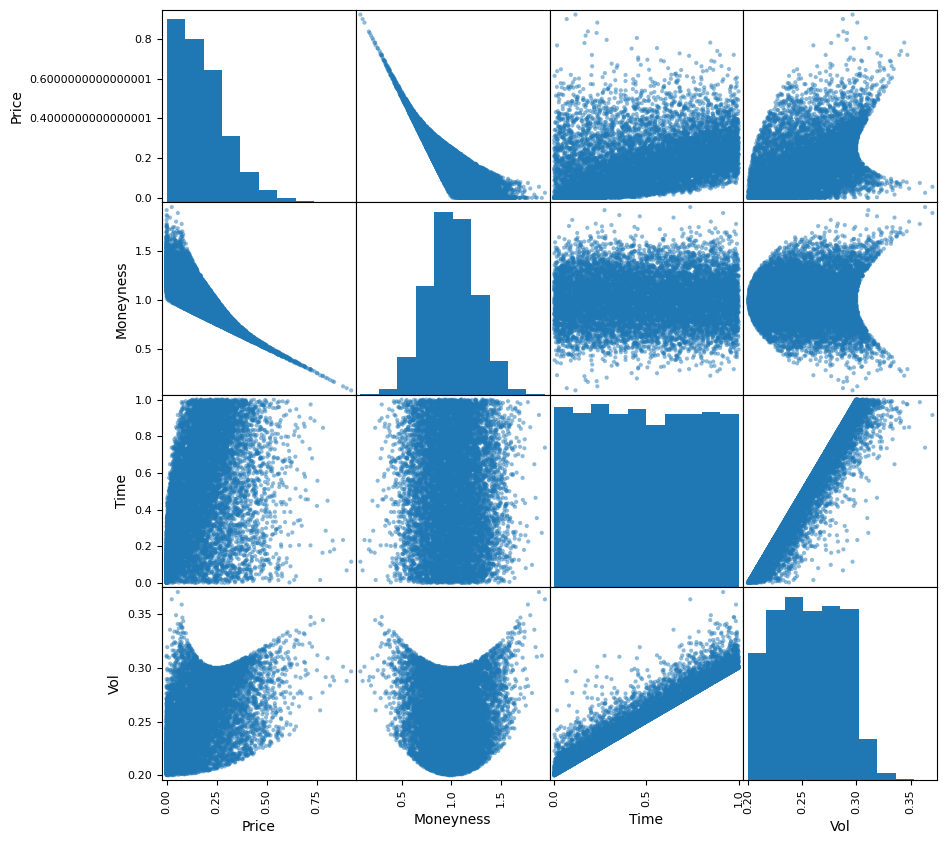

In [ ]:
plt.figure(figsize=(10,10))
scatter_matrix(df, figsize=(10,10))
plt.show()

As moneyness increases (strike price increases as compared to the stock price), the option price decreases. As time to maturity decreases, price also decreases. And as volatility increases price also increases.

In [ ]:
# SelectKBest is a feature selection class in sci-kit learn that selects the k best columns.  # f_regression using F-Statistic
# as the scoring function to evaluate the importance of each feature
# F-statistic compares variance by the feature. Higher f-stat suggests a more significant relationship between feature and target.
bestfeatures = SelectKBest(k='all', score_func=f_regression)

# Fits the features to the data. Calculates the F-stat score for each feature.
fit = bestfeatures.fit(X,Y)
# Scores represent the importance of each feature
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])


#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores.nlargest(10,'Score').set_index('Specs')

,Score
Specs,
Moneyness,28902.768205
Vol,2358.234665
Time,1658.441889


In [ ]:
from sklearn.model_selection import train_test_split

# 20% of data in the test split. Random_state = 42 ensures reproducibility.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
num_folds = 10
seed = 7


scoring = 'neg_mean_squared_error'

In [ ]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [ ]:
models.append(('MLP', MLPRegressor()))


In [ ]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [ ]:
# Stores the model namess
names = []
# CV results for each model
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)

    ## K Fold analysis:

    # Splits traning data into num_folds
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)


    # Full Training period
    res = model.fit(X_train, Y_train)
    # Calculates error comparing model's predictions on the target values in the training set
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000348 (0.000031) 0.000347 0.000350
LASSO: 0.017375 (0.001052) 0.017371 0.017687
EN: 0.017375 (0.001052) 0.017371 0.017687
KNN: 0.000014 (0.000005) 0.000007 0.000011
CART: 0.000010 (0.000002) 0.000000 0.000009
SVR: 0.005051 (0.000089) 0.005022 0.004959
MLP: 0.000050 (0.000052) 0.000040 0.000043
ABR: 0.000671 (0.000043) 0.000606 0.000635
GBR: 0.000021 (0.000001) 0.000017 0.000020
RFR: 0.000002 (0.000001) 0.000000 0.000002
ETR: 0.000001 (0.000000) 0.000000 0.000000


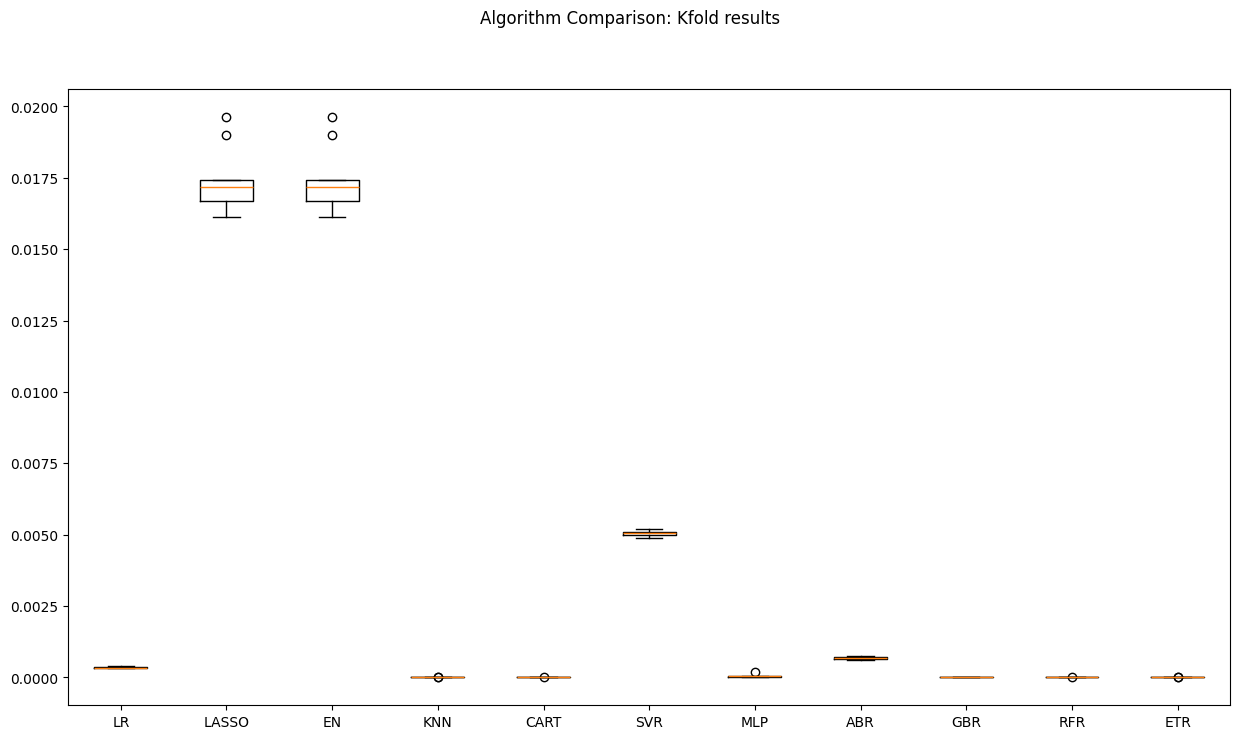

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

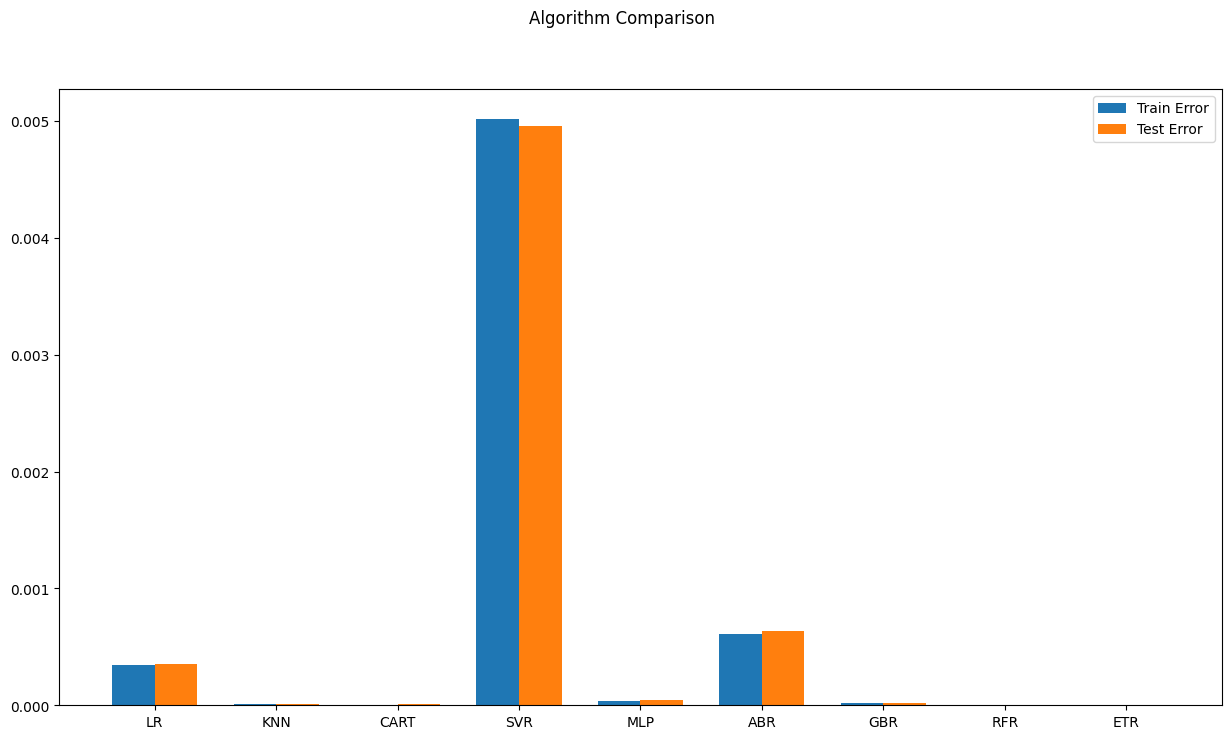

In [ ]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names)-2)  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results[0:1] + train_results[3:],  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results[0:1] + test_results[3:], width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:1] + names[3:])
pyplot.show()

The linear regression models perform the worse: Linear Regression, SupportVectorRegressor, AdaBoostRegressor.

This should be expected as from our scatter plots we can see price vs features are non-linear.



# Fine-tuning the ANN

In [ ]:
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000025 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000810 (0.000637) with: {'hidden_layer_sizes': (20,)}
-0.000173 (0.000195) with: {'hidden_layer_sizes': (50,)}
-0.000069 (0.000050) with: {'hidden_layer_sizes': (20, 20)}
-0.000025 (0.000009) with: {'hidden_layer_sizes': (20, 30, 20)}


In [ ]:
# prepare model
model_tuned = MLPRegressor(hidden_layer_sizes=(20, 30, 20))
model_tuned.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [ ]:
# estimate accuracy on validation set
# transform the validation dataset
predictions = model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

5.119838894270678e-06
